In [ ]:
########now part 2: decode and train#######

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12455067702093542274
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11271654605
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2800243769426591478
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import math
import timeit
import matplotlib.pyplot as plt
#from preprocess_func_new import *
from matplotlib.image import imread
import os
from os.path import expanduser

%matplotlib inline

#tf.enable_eager_execution()

#tf.logging.set_verbosity(tf.logging.INFO)

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
img_path = os.path.join('..','datasets','stixels')
img_path

'../datasets/stixels'

In [3]:
percent=2 

In [4]:
tfrec_batch_size=1 #for path name only

In [5]:
batch_size=32

In [6]:
tfrec_train_directory = os.path.join('..','datasets','stixels','train','tfrec_batch_size_'+str(tfrec_batch_size)+'_percent_'+str(percent))

In [7]:
#creating a list of paths to train tfrecs:
path_tfrecords_train_lst=[]
path_tfrecords_train = os.path.join(img_path, 'train')
for root, dirs, files in os.walk(tfrec_train_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_train_lst.append(os.path.join(tfrec_train_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')



In [8]:
#shortening the list for experiments
path_tfrecords_train_lst = path_tfrecords_train_lst[:100]
##################

In [8]:
#params
H=370 
W=24
C=3
img_shape = (H, W, C)
num_classes = 47

In [9]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    #######image = tf.decode_raw(image_raw, tf.int32) ####
    image = tf.image.decode_png(image_raw, channels=3, dtype=tf.uint8) 
    #image = tf.cast(image, tf.int32)

    # The type is now uint8 but we need it to be float.
    
    image = tf.cast(image, tf.float32) ####
    
    # Get the label associated with the image.
    label = parsed_example['label']

    # The image and label are now correct TensorFlow types.
    return image, label

In [14]:
########## a function to print tensor values
def print_tensor(tensor):
    dataset = tf.data.TFRecordDataset(filenames=[tensor])
    dataset = dataset.map(parse)
    iterator = dataset.make_one_shot_iterator()
    images_batch, labels_batch = iterator.get_next()
    x = {'image': images_batch}
    y = labels_batch
    init_op = tf.initialize_all_variables()

    with tf.Session() as sess:
        sess.run(init_op)
        print (sess.run(y))
        #print (sess.run(x))
        #return(sess.run(x))
    return

In [ ]:
################ try to print the tensors
for t in path_tfrecords_train_lst[:100]:
    #print (t)
    print_tensor(t)
    #print(x)

In [106]:
############# print shape of tensor
x2=tf.Session().run(x['image'])
x2.shape


(370, 24, 3)

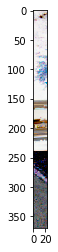

In [107]:
####################. show the parsed stixel
import matplotlib
%matplotlib inline
matplotlib.pyplot.imshow(x2)

In [10]:
def input_fn(filenames, train, batch_size=batch_size, buffer_size=100000): 
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)
    
    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        ######dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None #-1
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    #dataset = dataset.batch(batch_size)
    #dataset = tf.contrib.data.batch_and_drop_remainder(batch_size)
    dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    print(dataset.output_shapes)  # ==> "(16,)" (the batch dimension is known)
    
    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch
    
    return x, y

In [11]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train_lst, train=True)

In [46]:
###def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    # Reference to the tensor named "image" in the input-function.
    x = features["image"]
    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1,W,H,C])

    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=32, kernel_size=(3,3),
                           activation=None, strides=(2,2),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    
    net = tf.layers.separable_conv2d(inputs=net, filters=32,kernel_size=(3,3), strides=(1, 1),
                               activation=None,
                               depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               name='layer_conv_dw2', padding='SAME'
                              )
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
      
    net = tf.layers.separable_conv2d(inputs=net, filters=64,kernel_size=(3,3), strides=(2,2),
                                activation=None,
                                depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                name='layer_conv_dw3', padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)

    net = tf.layers.separable_conv2d(inputs=net, filters=128,kernel_size=(3,3), strides=(1,1),
                                activation=None,
                                depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                name='layer_conv_dw4', padding='SAME'
                                    )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)                           
    
    net = tf.layers.separable_conv2d(inputs=net, filters=128,kernel_size=(3,3), strides=(2,2),
                                activation=None,
                                depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                name='layer_conv_dw5', padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)         

    net = tf.layers.separable_conv2d(inputs=net, filters=256,kernel_size=(3,3), strides=(1,1),
                                activation=None,
                                depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                name='layer_conv_dw6', padding='SAME'
                               )

    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)     
    
    net = tf.layers.separable_conv2d(inputs=net, filters=256, kernel_size=(3,3), strides=(2,2),
                                activation=None,
                                depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                name='layer_conv_dw7', padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)     
    
    for i in range(5):
        net = tf.layers.separable_conv2d(inputs=net, filters=512, kernel_size=(3,3), strides=(1,1),
                                    activation=None,
                                    depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                    pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                    name='layer_conv_dw'+str(i+8), padding='SAME'
                                   )

        net = tf.layers.batch_normalization(inputs=net)

        net = tf.nn.relu6(features=net)  
    
    net = tf.layers.separable_conv2d(inputs=net, filters=512, kernel_size=(3,3), strides=(2,2),
                                activation=None,
                                depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                name='layer_conv_dw13', padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net) 
    
    net = tf.layers.separable_conv2d(inputs=net, filters=1024, kernel_size=(3,3), strides=(2,2),
                                activation=None,
                                depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                name='layer_conv_dw14', padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)     
    
    net = tf.layers.average_pooling2d(inputs=net, pool_size=(1,6), strides=(1,1), name='layer_pool15')
    
    # Flatten to a 2-rank tensor.
    #net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    net = tf.layers.flatten(net)


    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc16',
                          units=47,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1) 
   
    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred)# _cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        tf.argmax(logits)
        #loss = tf.losses.mean_squared_error(labels=labels, predictions=logits)
        loss = tf.reduce_mean(cross_entropy)
 #######################
        lr = 1e-2
        step_rate = 1000
        decay = 0.5 #if this equals 1 the lr stays the same

        #global_step = tf.Variable(0, trainable=False)
        #increment_global_step = tf.assign(global_step, global_step + 1)

        learning_rate = tf.train.exponential_decay(lr, global_step=tf.train.get_or_create_global_step(), 
                                           decay_steps=step_rate, decay_rate=decay, staircase=True)
        

        
        # Define the optimizer for improving the neural network.
        #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) 
        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_or_create_global_step())
        

#############################        


        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls) #TODO change acc method
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
        
#         with tf.Session() as sess:
#             print('Learning rate: %f' % (sess.run(optimizer._learning_rate)))
        
    return spec

In [68]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    # Reference to the tensor named "image" in the input-function.
    x = features["image"]
    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1,W,H,C])

    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=32, kernel_size=(3,3),
                           activation=None, strides=(2,2),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    ###
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None,kernel_size=(3,3), stride=(1, 1),
                               activation_fn=None, depth_multiplier=1,
                               weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               padding='SAME'
                              )
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    net = tf.layers.conv2d(inputs=net, name='point_wize3',
                           filters=32, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    ####
    
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    net = tf.layers.conv2d(inputs=net, name='point_wize5',
                           filters=64, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    ####

    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(1,1),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                                    )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)  
    
    net = tf.layers.conv2d(inputs=net, name='point_wize7',
                           filters=128, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    ####
    
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)    
    
    net = tf.layers.conv2d(inputs=net, name='point_wize9',
                           filters=128, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    ####

    net = tf.contrib.layers.separable_conv2d(inputs=net,num_outputs=None, kernel_size=(3,3), stride=(1,1),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )

    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)  
    
    net = tf.layers.conv2d(inputs=net, name='point_wize11',
                           filters=256, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    
    ###
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)    
    
    net = tf.layers.conv2d(inputs=net, name='point_wize13',
                           filters=256, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    
    ###
    
    for i in range(5):
        net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(1,1),
                                    activation_fn=None, depth_multiplier=1,
                                    weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                    padding='SAME'
                                   )

        net = tf.layers.batch_normalization(inputs=net)

        net = tf.nn.relu6(features=net)  
        
        net = tf.layers.conv2d(inputs=net, name='point_wize'+str(i+14),
                           filters=512, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
        net = tf.layers.batch_normalization(inputs=net)
    
        net = tf.nn.relu6(features=net)
    
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net) 
    
    net = tf.layers.conv2d(inputs=net, name='point_wize19',
                           filters=512, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    
    ###
    
    net = tf.contrib.layers.separable_conv2d(inputs=net, num_outputs=None, kernel_size=(3,3), stride=(2,2),
                                activation_fn=None, depth_multiplier=1,
                                weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                padding='SAME'
                               )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)    
    
    net = tf.layers.conv2d(inputs=net, name='point_wize20',
                           filters=1024, kernel_size=(1,1),
                           activation=None, strides=(1,1),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    
    net = tf.layers.batch_normalization(inputs=net)
    
    net = tf.nn.relu6(features=net)
    
    
    ###
    
    net = tf.layers.average_pooling2d(inputs=net, pool_size=(1,6), strides=(1,1), name='layer_pool21')
    
    # Flatten to a 2-rank tensor.
    #net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    net = tf.layers.flatten(net)


    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc22',
                          units=47,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1) 
   
    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred)# _cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        tf.argmax(logits)
        #loss = tf.losses.mean_squared_error(labels=labels, predictions=logits)
        loss = tf.reduce_mean(cross_entropy)
 #######################
        lr = 1e-0
        step_rate = 1000
        decay = 0.5 #if this equals 1 the lr stays the same

        #global_step = tf.Variable(0, trainable=False)
        #increment_global_step = tf.assign(global_step, global_step + 1)

        learning_rate = tf.train.exponential_decay(lr, global_step=tf.train.get_or_create_global_step(), 
                                           decay_steps=step_rate, decay_rate=decay, staircase=True)
        

        
        # Define the optimizer for improving the neural network.
        #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) 
        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_or_create_global_step())
        

#############################        


        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls) #TODO change acc method
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
        
#         with tf.Session() as sess:
#             print('Learning rate: %f' % (sess.run(optimizer._learning_rate)))
        
    return spec

In [69]:
params = {} #{"learning_rate": 1e-5}

In [70]:
def make_dir_and_comment(model_dir):
    home = expanduser("~")
    log_name=os.path.join('logs/', model_dir + '.txt')
    
    if os.path.isdir(model_dir):
        print('INFO: dir with name ' + model_dir + ' already exist.')
    
    new_comment=input('Please add a comment\n')
    
    if os.path.exists(log_name):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    
    model_log = open(log_name,append_write)
    model_log.write(home +' : '+ new_comment + '\n')
    model_log.close()
    return



In [71]:
model_dir = './ckpts_26_5_mobilenet1_all_16_layers_all_examples_PW' #'./ckpts_<day>_<month>_<architecture>_<main_change>'
make_dir_and_comment(model_dir) 
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir=model_dir,
                               config=tf.estimator.RunConfig(save_checkpoints_steps=1000, save_summary_steps=100)
                              )

Please add a comment

INFO:tensorflow:Using config: {'_model_dir': './ckpts_26_5_mobilenet1_all_16_layers_all_examples_PW', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff581107a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
model.train(input_fn=train_input_fn, steps=40000)

(TensorShape([Dimension(32), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(32)]))
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./ckpts_26_5_mobilenet1_all_16_layers_all_examples_PW/model.ckpt.
INFO:tensorflow:loss = 3.8501477, step = 0
INFO:tensorflow:global_step/sec: 1.49382
INFO:tensorflow:loss = 3.338158, step = 100 (66.945 sec)
INFO:tensorflow:global_step/sec: 1.59736
INFO:tensorflow:loss = 3.5250683, step = 200 (62.603 sec)
INFO:tensorflow:global_step/sec: 1.59531
INFO:tensorflow:loss = 3.3767085, step = 300 (62.684 sec)
INFO:tensorflow:global_step/sec: 1.59503
INFO:tensorflow:loss = 3.4972868, step = 400 (62.693 sec)
INFO:tensorflow:global_step/sec: 1.60164
INFO:tensorflow:loss = 3.474795, step = 500 (62.437 sec)
INFO:t

In [ ]:
###DONE TRAIN###

In [ ]:
#VAL:

In [159]:
tfrec_val_batch_size=1

In [160]:
tfrec_val_directory = os.path.join('..','datasets','stixels','val','tfrec_batch_size_'+str(tfrec_val_batch_size)+'_percent_'+str(percent))

In [161]:
path_tfrecords_val_lst=[]
path_tfrecords_val = os.path.join(img_path, 'val')
for root, dirs, files in os.walk(tfrec_val_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_val_lst.append(os.path.join(tfrec_val_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [162]:
def val_input_fn():
    return input_fn(path_tfrecords_val_lst[7000:8500], train=False) 

In [163]:
val_result = model.evaluate(input_fn=val_input_fn) 

(TensorShape([Dimension(32), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(32)]))
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-25-18:16:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_25_5_mobilenet1_3layers_all_examples_v4/model.ckpt-34006
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-25-18:16:02
INFO:tensorflow:Saving dict for global step 34006: accuracy = 0.07269022, global_step = 34006, loss = 3.294152


In [164]:
val_result

{'accuracy': 0.07269022, 'global_step': 34006, 'loss': 3.294152}

In [165]:
print("Classification val accuracy: {0:.2%}".format(val_result["accuracy"]))

Classification val accuracy: 7.27%


In [ ]:
#TEST:

In [104]:
tfrec_test_batch_size=1

In [105]:
tfrec_test_directory = os.path.join('..','datasets','stixels','test','tfrec_batch_size_'+str(tfrec_test_batch_size))

In [106]:
path_tfrecords_test_lst=[]
path_tfrecords_test = os.path.join(img_path, 'test')
for root, dirs, files in os.walk(tfrec_test_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_test_lst.append(os.path.join(tfrec_test_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [168]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_train_lst[:5000], train=False) #path_tfrecords_test_lst[1000:3000], train=False)

In [169]:
test_result = model.evaluate(input_fn=test_input_fn)

(TensorShape([Dimension(32), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(32)]))
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-25-18:18:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_25_5_mobilenet1_3layers_all_examples_v4/model.ckpt-34006
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-25-18:18:09
INFO:tensorflow:Saving dict for global step 34006: accuracy = 0.075921476, global_step = 34006, loss = 3.2370234


In [170]:
print("Classification test accuracy: {0:.2%}".format(test_result["accuracy"]))

Classification test accuracy: 7.59%


In [171]:
#PRED:

In [172]:
sum_csv_test_path = os.path.join(img_path,'train', 'sum_csv') #TEST
labels_test=pd.read_csv(os.path.join(sum_csv_test_path,'labels_train_'+str(percent)+'percent.csv'))
test_names_list=list(labels_test['Name'])
image_paths_test=[]
for name in test_names_list:
    image_paths_test.append(os.path.join(img_path, 'train', name+'.png')) #maybe no need to add '.png'


In [173]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    # Convert to a numpy array and return it.
    return np.asarray(images)


In [174]:
##TODO:SHUFFLE!
some_num=100
some_images = load_images(image_paths=image_paths_test[0:0+some_num])
some_images_cls = np.array(labels_test['Label'])

In [175]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

In [176]:
predictions = model.predict(input_fn=predict_input_fn) 

In [177]:
cls_pred = np.array(list(predictions))
cls_pred 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_25_5_mobilenet1_3layers_all_examples_v4/model.ckpt-34006
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([[0.01553465, 0.01467996, 0.01736307, ..., 0.01505905, 0.01597004,
        0.02579576],
       [0.01551782, 0.01461374, 0.01731868, ..., 0.01502423, 0.01593275,
        0.02578057],
       [0.01550467, 0.01454181, 0.01727047, ..., 0.01499285, 0.01589379,
        0.02575913],
       ...,
       [0.01537089, 0.0143695 , 0.01709602, ..., 0.01490644, 0.01576519,
        0.0259079 ],
       [0.01539997, 0.01443391, 0.0171425 , ..., 0.01494984, 0.01580926,
        0.02588672],
       [0.0154251 , 0.01447382, 0.01717931, ..., 0.01497578, 0.01585171,
        0.02589413]], dtype=float32)

In [178]:
cls_pred.shape

(100, 47)

In [179]:
cls_pred

array([[0.01553465, 0.01467996, 0.01736307, ..., 0.01505905, 0.01597004,
        0.02579576],
       [0.01551782, 0.01461374, 0.01731868, ..., 0.01502423, 0.01593275,
        0.02578057],
       [0.01550467, 0.01454181, 0.01727047, ..., 0.01499285, 0.01589379,
        0.02575913],
       ...,
       [0.01537089, 0.0143695 , 0.01709602, ..., 0.01490644, 0.01576519,
        0.0259079 ],
       [0.01539997, 0.01443391, 0.0171425 , ..., 0.01494984, 0.01580926,
        0.02588672],
       [0.0154251 , 0.01447382, 0.01717931, ..., 0.01497578, 0.01585171,
        0.02589413]], dtype=float32)

In [180]:
np.histogram(cls_pred, bins=47)

(array([ 14,   7,  73,  65,  89,  78, 138,  36,  42, 188, 161, 300, 100,
        132, 179, 140, 185, 170, 194, 170,  41, 118,  68, 130, 103, 157,
        119, 163,  98, 121,  16,  89,  37, 113, 131,  53, 149, 105,  25,
         19, 108, 134,  61,  55,  16,   2,   8]),
 array([0.01345151, 0.01381646, 0.01418142, 0.01454637, 0.01491132,
        0.01527627, 0.01564123, 0.01600618, 0.01637113, 0.01673609,
        0.01710104, 0.01746599, 0.01783094, 0.0181959 , 0.01856085,
        0.0189258 , 0.01929076, 0.01965571, 0.02002066, 0.02038561,
        0.02075057, 0.02111552, 0.02148047, 0.02184542, 0.02221038,
        0.02257533, 0.02294028, 0.02330524, 0.02367019, 0.02403514,
        0.02440009, 0.02476505, 0.02513   , 0.02549495, 0.02585991,
        0.02622486, 0.02658981, 0.02695476, 0.02731972, 0.02768467,
        0.02804962, 0.02841458, 0.02877953, 0.02914448, 0.02950943,
        0.02987439, 0.03023934, 0.03060429]))

In [181]:
cls_pred[11]

array([0.0154098 , 0.01443989, 0.01715581, 0.01598581, 0.01700384,
       0.0183249 , 0.01950242, 0.01777318, 0.01865833, 0.01885753,
       0.01814145, 0.02042307, 0.02011318, 0.01966018, 0.0189752 ,
       0.02137644, 0.0266495 , 0.02149086, 0.01999688, 0.02197511,
       0.02349279, 0.02489726, 0.0226072 , 0.02047303, 0.0228858 ,
       0.02045605, 0.02595181, 0.02825818, 0.02919916, 0.02705002,
       0.02356324, 0.02570057, 0.02852751, 0.02849744, 0.02681281,
       0.02422464, 0.02287525, 0.02238471, 0.02391515, 0.01962268,
       0.01762871, 0.01711534, 0.01756331, 0.0176945 , 0.0149594 ,
       0.01583619, 0.02589383], dtype=float32)

In [182]:
y_pred_cls = tf.argmax(cls_pred, axis=1) 

In [183]:
y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(100,) dtype=int64>

In [184]:
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
        sess.run(init_op)
        print (sess.run(y_pred_cls))

[28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28]
